# Human-In-Context: Body pose

Datagen's generators offer human-centric data, both statis and in motion. In addition to our Faces generator, we now offer Humans in Context data - short animations of humans interacting with a certain scene, portraying a certain behaviour. For example, we could have a sequence of a driver falling asleep at the wheel, or a person performing jumping jacks in front of their mirror. 
<br><br>
These sequences are useful for a huge variaty of tasks - from awareness estimation in the In-Cabin domain, to suspicious behaviour detection in the Home Security domain. For an example of using HIC data, [check out our paper](https://arxiv.org/abs/2206.00148?context=cs) "Hands-Up: Leveraging Synthetic Data for Hands-On-Wheel Detection" (Neurips 2022).


# Imports

In [5]:
import random
from os.path import join
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
from dghelpers import imshow
from dghelpers import hic_visualize_pose
import datagen

random.seed(151)

## Datapoint path definition

In [6]:
DATASET_PATH = '../resources/hic_in_cabin'

dp = datagen.load(DATASET_PATH, dataset_config = datagen.DatasetConfig(environment="hic"))[0]

## The easy way

We have implemented a function that lets you visualize the skeleton out of the box. You can get away with it if you don't want to dive into the implementaion


DataPoint(visible_spectrum_image_name='visible_spectrum.png', frame_num=1, camera='media_dashboard_camera', scene_path=PosixPath('../resources/hic_in_cabin/scene_00001'))


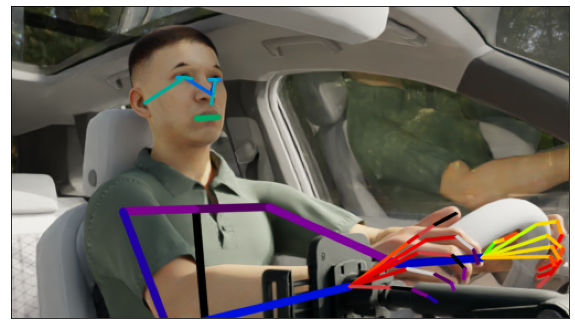

In [7]:
imshow(hic_visualize_pose(dp, skeleton=True))

DataPoint(visible_spectrum_image_name='visible_spectrum.png', frame_num=1, camera='media_dashboard_camera', scene_path=PosixPath('../resources/hic_in_cabin/scene_00001'))


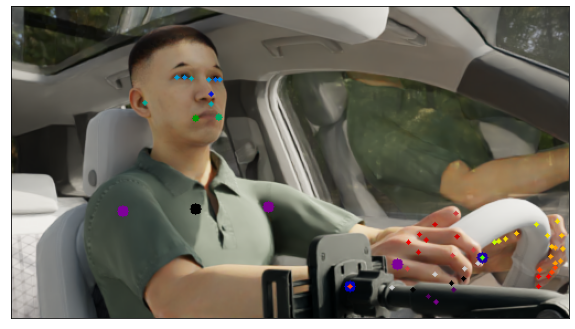

In [8]:
imshow(hic_visualize_pose(dp, skeleton=False))

# Implementation details

<b>The steps below are relevant only if you want to change the way the keypoints are displayed</b>

## Data Pre-processing

Recursively extract the relevant data from the dictionary and format it as a numpy array

Let's create a simple tree implementation for the skeleton's kinematic tree

In [10]:
class Node:
    def __init__(self, data, children=None):
        if hasattr(data, 'coords_2d'):
            data = data.coords_2d
        self.data = data
        if children is not None:
            self.children = children
        else:
            self.children = []

We'll now build the body's kinematic tree

In [11]:
hands = dp.keypoints.hand
body = dp.keypoints.body

for side in ('left', 'right'):
    get_finger_tree = lambda finger : Node(finger.mcp, [Node(finger.pip, [Node(finger.dip, [Node(finger.tip)])])])
    
    # We begin with building the kinematic tree of each of the fingers separately
    fingers = getattr(hands, side).finger
    thumb = fingers.thumb
    thumb_tree = Node(thumb.cmc, [Node(thumb.mcp, [Node(thumb.ip, [Node(thumb.tip)])])])
    index_tree = get_finger_tree(fingers.index)
    middle_tree = get_finger_tree(fingers.middle)
    ring_tree = get_finger_tree(fingers.ring)
    pinky_tree = get_finger_tree(fingers.pinky)

    # We can build the hand tree from all of the fingers
    hand_tree = Node(getattr(hands, side).wrist, [thumb_tree, index_tree, middle_tree, ring_tree, pinky_tree])

    # We do the same with arms, legs and eyes
    arm_tree = Node(getattr(body.shoulder, side), [Node(getattr(body.elbow, side), [Node(getattr(body.wrist, side))])])
    leg_tree = Node(getattr(body.hip, side), [Node(getattr(body.knee, side), [Node(getattr(body.ankle, side), [Node(getattr(body.foot, side).index)])])])

    eye = getattr(body.eye, side)
    eye_tree = Node(eye.center, [Node(eye.outer), Node(eye.inner), Node(getattr(body.ear, side))])

    if side == 'left':
        left_hand_tree = hand_tree
        left_arm_tree = arm_tree
        left_leg_tree = leg_tree
        left_eye_tree = eye_tree
    elif side == 'right':
        right_hand_tree = hand_tree
        right_arm_tree = arm_tree
        right_leg_tree = leg_tree
        right_eye_tree = eye_tree

# We create two new nodes at the center of the shoulders and the hips
hips_center_position = np.mean([left_leg_tree.data, right_leg_tree.data], axis=0).astype('int')
shoulders_center_position = np.mean([left_arm_tree.data, right_arm_tree.data], axis=0).astype('int')

# We can finally create the whole body and face trees
lower_body_tree = Node(hips_center_position, [left_leg_tree, right_leg_tree])
mouth_tree = Node(body.mouth.left, [Node(body.mouth.right)])
upper_face_tree = Node(body.nose, [left_eye_tree, right_eye_tree])
body_tree = Node(shoulders_center_position, [lower_body_tree, left_arm_tree, right_arm_tree])

## Skeleton visualization

Now that we have the kinematic tree, drawing the skeleton is straightforward.<br>
<b>draw_skeleton</b> is a function that recursively draws the links between a node and its children

In [12]:
nrof_colors = 30
cmap = plt.cm.get_cmap('nipy_spectral', nrof_colors)
def draw_skeleton(img, node, thickness, cmap_idx=0):
    for child in node.children:
        color = (np.array(cmap(cmap_idx % nrof_colors))[:3]*255).astype('int').tolist()
        cmap_idx += 1
        cv2.line(img, np.flip(node.data), np.flip(child.data), color=color, thickness=thickness, lineType=cv2.LINE_AA)
        draw_skeleton(img, child, thickness, cmap_idx+1)

We load the image and draw the different parts of the skeletons separately

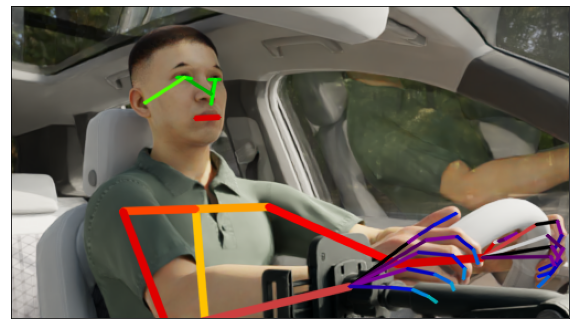

In [13]:
img = dp.visible_spectrum.copy()

draw_skeleton(img, body_tree, 5, cmap_idx=random.randint(0, nrof_colors))
draw_skeleton(img, upper_face_tree, 2, cmap_idx=random.randint(0, nrof_colors))
draw_skeleton(img, mouth_tree, 3, cmap_idx=random.randint(0, nrof_colors))
draw_skeleton(img, left_hand_tree, 2, cmap_idx=random.randint(0, nrof_colors))
draw_skeleton(img, right_hand_tree, 2, cmap_idx=random.randint(0, nrof_colors))

imshow(img)

## Body keypoints

Alternatively, we can choose to draw only the keypoints without the skeleton. The procedure is similar:

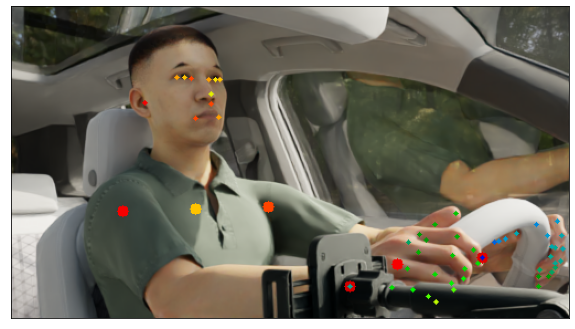

In [14]:
def draw_keypoints(img, node, thickness, cmap_idx=0):
    color = (np.array(cmap(cmap_idx % nrof_colors))[:3]*255).astype('int').tolist()
    cv2.circle(img, np.flip(node.data), thickness, color, -1)
    for child in node.children:
        cmap_idx +=1
        draw_keypoints(img, child, thickness, cmap_idx)


img = dp.visible_spectrum.copy()

draw_keypoints(img, body_tree, 5, cmap_idx=random.randint(0, nrof_colors))
draw_keypoints(img, upper_face_tree, 2, cmap_idx=random.randint(0, nrof_colors))
draw_keypoints(img, mouth_tree, 2, cmap_idx=random.randint(0, nrof_colors))
draw_keypoints(img, left_hand_tree, 2, cmap_idx=random.randint(0, nrof_colors))
draw_keypoints(img, right_hand_tree, 2, cmap_idx=random.randint(0, nrof_colors))

imshow(img)